# SOTA / WWFF Overlaps for Ireland

Summits on the Air and Word Wide Flora and Fauna are programes that may be undertaken by licenced amater radio operators. For more on amatatur radio in Ireland see www.irts.ie

Recently some extra entities got added to the WWFF (https://wwff.co/) database for Ireland. These are mainly, if not all, Special Areas of Conservation (SAC's); though not all SAC's are listed.

SOTA (https://www.sota.org.uk/) seems to have been a more popular amateur radio activity, but many of the SOTA summits are also within National Parks and SAC's. What this notebook aims to do is find which ones.

## SAC /WWFF Data
The WWFF clearly state on their website - "No part of this directory may be reproduced, stored in a retrieval system or transmitted in any form or by any means without the prior permission of WWFF". That's a silly attitude to take on what is basically public data of parks. But fine, if they want to be like that... 
The site also says in a post from December 2021 that Ireland it it's latest member. This is also odd, since Ireland has had it's national parks and state forests in the database since at least 2010.

Anyway... For Ireland the National Parks and Wildlife Service have shapefiles for SACs at https://data.gov.ie/dataset/special-areas-of-conservation This uses ITM. I'm making an incorrect assumption that all SAC's are also entities in the WWFF, and I'm also not listing the WWFF codes for the SAC's. You can do this yourself or complain to the WWFF about their attitude to data sharing. 

## SOTA Summits
SOTA is much more open with it's data with lots to explore on www.sotadata.org.uk. These are listed in a CSV file in https://www.sotadata.org.uk/summitslist.csv which we can transform to ITM. 

## Counties Basemap
The Census office has a handy 'basemap' of Irish Counties which can be downloaded from https://census.cso.ie/censusasp/saps/boundaries/ED_SA%20Disclaimer1.htm This is in Irish Grid which can be transformed to ITM.

## Outputs
We create a map showing the SOTA summits that are in parks and indicate the parks. There are too many to annotate them the usual way.

There is also a table showing the SOTA Summits and the SAC they are in.


In [41]:
%pylab inline
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from pyproj import Transformer
from shapely.geometry import Point

figsize(30, 20)
matplotlib.rcParams.update({'font.size': 22})
pd.set_option("display.max_rows", None, "display.max_columns", None)

Populating the interactive namespace from numpy and matplotlib


/Users/albertw/venv/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['dtype']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [51]:
# SACs
gdf = gpd.read_file("~/Downloads/SAC_ITM_2021_10/SAC_ITM_2021_10.shp")

# Basemap
base = gpd.read_file("~/Downloads/Census2011_Admin_Counties_generalised20m/Census2011_Admin_Counties_generalised20m.shp")

# SOTA
url="https://www.sotadata.org.uk/summitslist.csv"

dtype={"GridRef1": "string", "GridRef2": "string"}
names=["SummitCode", "AssociationName", "RegionName", "SummitName", 
       "AltM", "AltFt", "GridRef1", "GridRef2", "Longitude", "Latitude", "Points",
       "BonusPoints", "ValidFrom", "ValidTo", "ActivationCount", "ActivationDate",
       "ActivationCall"]

sotadf=pd.read_csv(url, skiprows=2, names=names, dtype=dtype)
sotadf = sotadf[sotadf.AssociationName == "Ireland"]


In [8]:
def toitm(lat, lon):
    """ Return the ITM of a given WSG84 lat, lon
    """
    transformer = Transformer.from_crs("epsg:4326", "epsg:2157")
    return transformer.transform(lat, lon)

def towgs(lat, lon):
    """ Return the WSG84 of a given northing easting
    """
    transformer = Transformer.from_crs("epsg:2157", "epsg:4326")
    return transformer.transform(lat, lon)


In [9]:
def sotaeiff():
    """ Return a dictionary of sota summits that are in SACs and the SAC they are in.
        Assuming that a summit can be in only one SAC, i.e. that SAC's dont overlap"""

    sotaeiff = {}
    for index, sota in sotadf.iterrows():
        summit = Point(toitm(sota.Latitude, sota.Longitude))
        for i, eiff in gdf.iterrows():
            if eiff.geometry.contains(summit):
                sotaeiff[sota.SummitCode] = eiff.SITECODE

    return sotaeiff



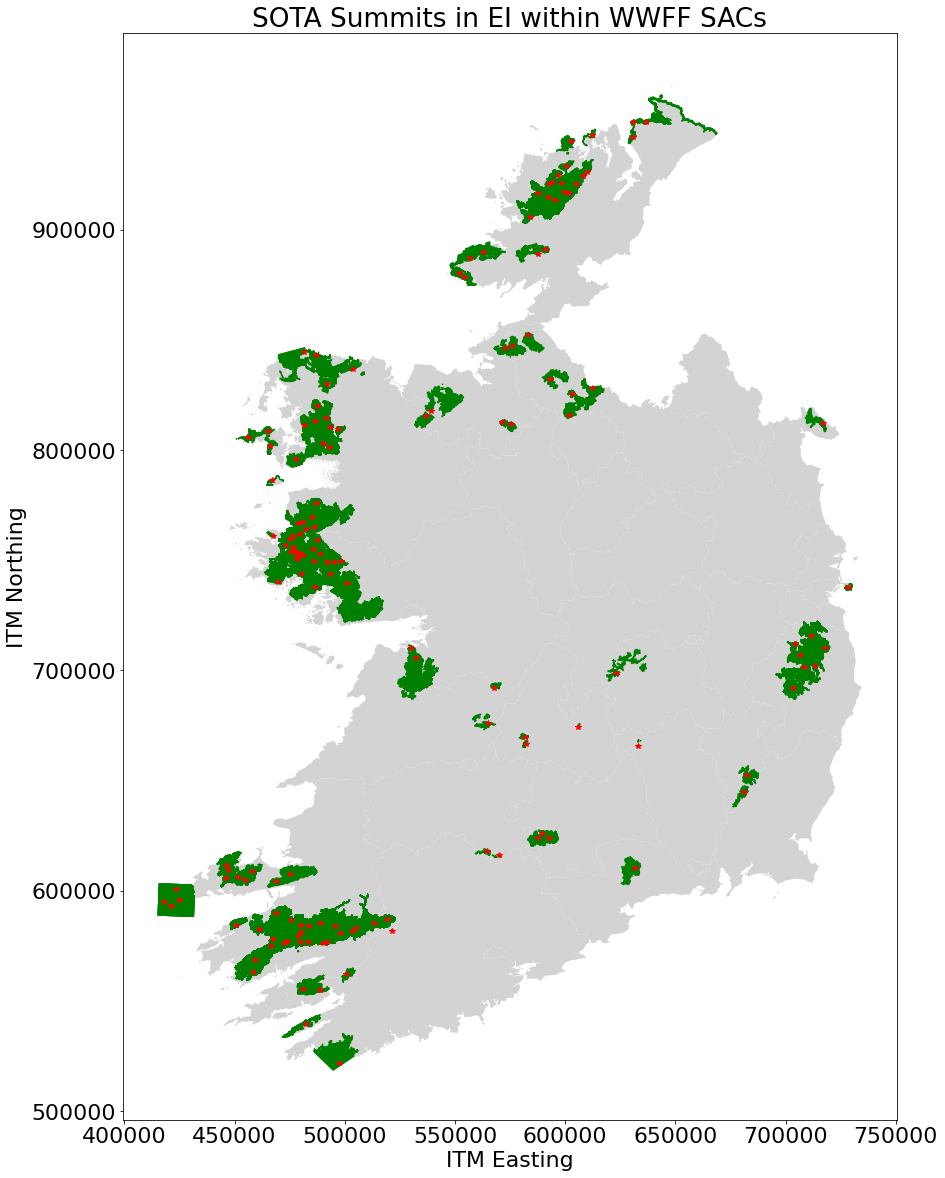

In [13]:
sotas = sotaeiff()

# Print a basemap
# We need to translate from Irish Grid to ITM
fig, ax = plt.subplots()
base.translate(400000,500000).plot(ax=ax, color='lightgrey')

# There is probably a much more efficient way to do 
# the following, but given the number of datapoints it doesn't take too long...
# Plot the SAC's with Summits
for summit in sotas.keys():
    summitdf = sotadf[sotadf.SummitCode == summit]
    summitpoint = Point(toitm(summitdf.Latitude, summitdf.Longitude))
    # There may be multiple rows for each SAC
    for eiff in gdf[gdf.SITECODE == sotas[summit]].iterrows():
        eiff = eiff[1]
        try:
            plt.fill(*eiff.geometry.exterior.xy, color="green")
        except AttributeError as e:
            # Some are multipolygon
            for geom in eiff.geometry.geoms:
                 plt.fill(*geom.exterior.xy, color="green")
    
# Plot the Summits over the SACs
for summit in sotas.keys():
    summitdf = sotadf[sotadf.SummitCode == summit]
    summitpoint = Point(toitm(summitdf.Latitude, summitdf.Longitude))
    plt.plot(summitpoint.x, summitpoint.y, marker='*', markersize=6,color="red")
    # There are too many points together to annotate
    #ax.annotate(summit, (summitpoint.x, summitpoint.y),fontsize=10, color="red")
    
plt.title("SOTA Summits in EI within WWFF SACs")
plt.xlabel('ITM Easting')
plt.ylabel('ITM Northing')
plt.show()

In [54]:
# Create a table of the summits in SACs

# Turn the disctionary into a dataframe
data_list = list(sotas.items())
df = pd.DataFrame(data_list, columns=["SummitCode","SITECODE"])

# Merge in the SACs and display
newdf = df.merge(sotadf)
newdf = newdf.merge(gdf)
newdf.drop_duplicates(subset='SummitCode', inplace=True)
newdf[['SummitCode','SummitName','Points','BonusPoints','ActivationCount','COUNTY','SITE_NAME']]

,SummitCode,SummitName,Points,BonusPoints,ActivationCount,COUNTY,SITE_NAME
0,EI/IE-001,Lugnaquilla,10,3,20,wi,Wicklow Mountains SAC
2,EI/IE-002,Mullaghcleevaun,10,3,18,wi,Wicklow Mountains SAC
4,EI/IE-003,Tonelagee,10,3,41,wi,Wicklow Mountains SAC
6,EI/IE-005,Kippure,10,3,41,wi,Wicklow Mountains SAC
8,EI/IE-007,Djouce,10,3,36,wi,Wicklow Mountains SAC
10,EI/IE-012,Scarr,8,3,20,wi,Wicklow Mountains SAC
12,EI/IE-014,Sorrel Hill,6,3,26,wi,Wicklow Mountains SAC
14,EI/IE-004,Mount Leinster,10,3,19,"cw, wx",Blackstairs Mountains SAC
15,EI/IE-006,Blackstairs Mountain,10,3,6,"cw, wx",Blackstairs Mountains SAC
16,EI/IE-009,Keeper Hill,8,3,10,ti,Keeper Hill SAC
